# Crime and Weather

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})
import pytz
import datetime

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

/home/jsaxon/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Variations in Chicago.
We are well-acquainted with the correlated variation in crime and weather, in Chicago.

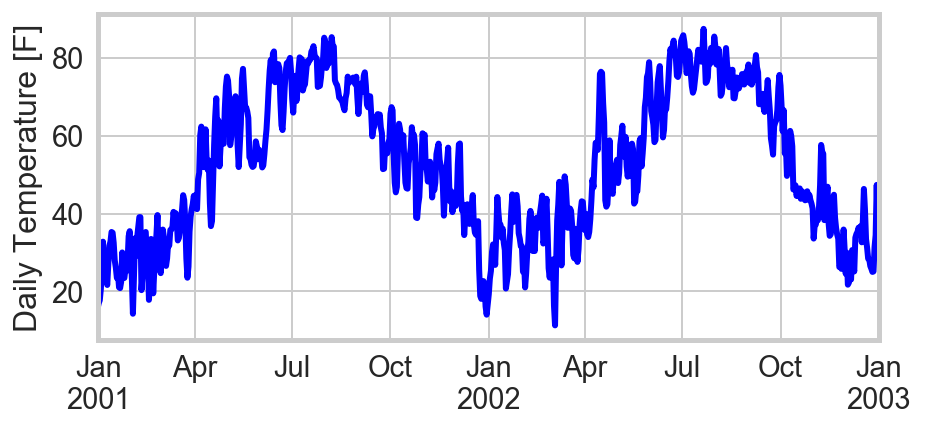

In [2]:
weather_mdw = pd.read_csv("data/MDW_new.csv",
                          names = ["Date", "Temperature [F]", "Precipitation [In]"],
                          index_col = "Date", parse_dates = ["Date"], 
                          infer_datetime_format = True)

weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

# There are a few readings with temperatures below abs. zero.
weather_mdw = weather_mdw[weather_mdw["Temperature [F]"] > -500].resample("1D").mean()
# weather_mdw = weather_mdw[["Temperature [F]", "Precipitation [In]"]].resample("1D").mean()

ax = weather_mdw["Temperature [F]"].plot(c = "b")
ax.set_xlabel("")
ax.set_ylabel("Daily Temperature [F]");

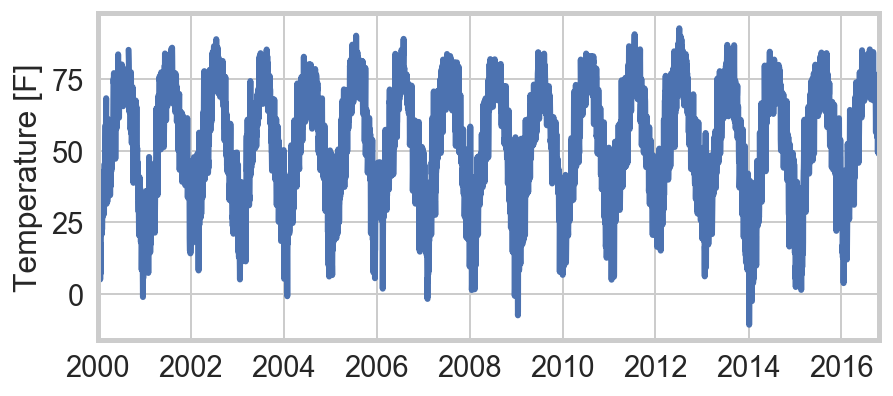

In [3]:
weather_mdw = pd.read_csv("/media/jsaxon/brobdingnag/data/weather/MDW.csv", 
                          index_col = "DateUTC", parse_dates = ["DateUTC"], 
                          usecols = ["DateUTC", "Temperature [F]", "Precipitation [In]"])

weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

weather_mdw = weather_mdw[["Temperature [F]", "Precipitation [In]"]].resample("1D").mean()
ax = weather_mdw["Temperature [F]"].plot()
ax.set_ylabel("Temperature [F]")
ax.set_xlabel("");

In [4]:
# This is just wildly faster by command line.
# If need be, we can make it python
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv \
#       | cut -f3 -d"," | cut -f1 -d " " \
#       | sed "s/\(..\)\/\(..\)\/\(....\)/\3\/\1\/\2/" \
#       | sort | uniq -c | grep -v "[A-Z]" \
#       > chicago_crime_counts.csv

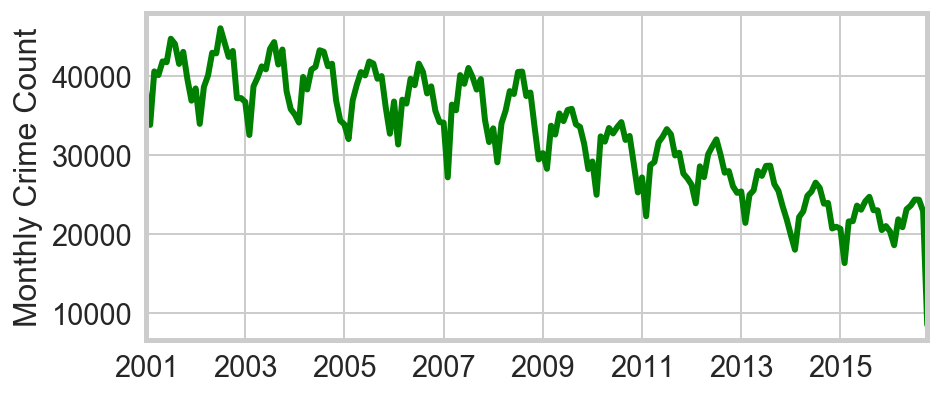

In [5]:
daily_crimes = pd.read_csv("chicago_crime_counts.csv", index_col = "Date", parse_dates = True,
                           delim_whitespace = True, names = ["Count", "Date"])

daily_crimes.set_index(daily_crimes.index.tz_localize(pytz.timezone('US/Central')), inplace = True)
ax = daily_crimes["Count"].resample("1M").sum().plot(c = "g")#, title = "Monthly Crime Count in Chicago")
ax.set_xlabel("")
ax.set_ylabel("Monthly Crime Count");

## Warm Places: It's Not Sunlight
Loading crime data from San Francisco, Dallas, and Phoenix (grouped at the monthly level) suggests that the temperature variations are actually importnt: it's not just daylight or the school calendar.

In [6]:
sf_crime = pd.read_csv("/media/jsaxon/brobdingnag/data/crime/san_francisco_ca.csv", 
                       usecols = ["Date", "Time", "Category"], infer_datetime_format = True,
                       parse_dates = [["Date", "Time"]], index_col = "Date_Time")
sf_crime.index.name = "Date"
sf_crime = sf_crime[(sf_crime["Category"] != "NON-CRIMINAL") & (sf_crime.index.date < datetime.date(2017, 6, 1))]

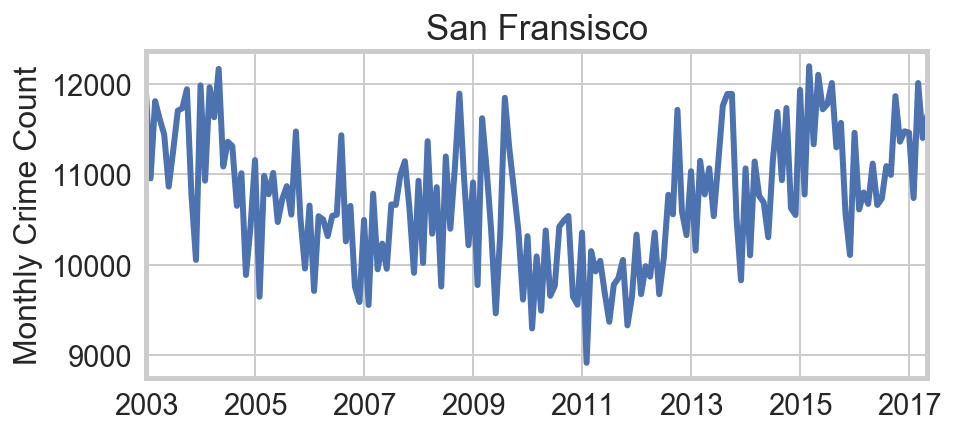

In [7]:
ax = sf_crime["Category"].resample("1M").count().plot(title = "San Fransisco")
ax.set_ylabel("Monthly Crime Count")
ax.set_xlabel("");

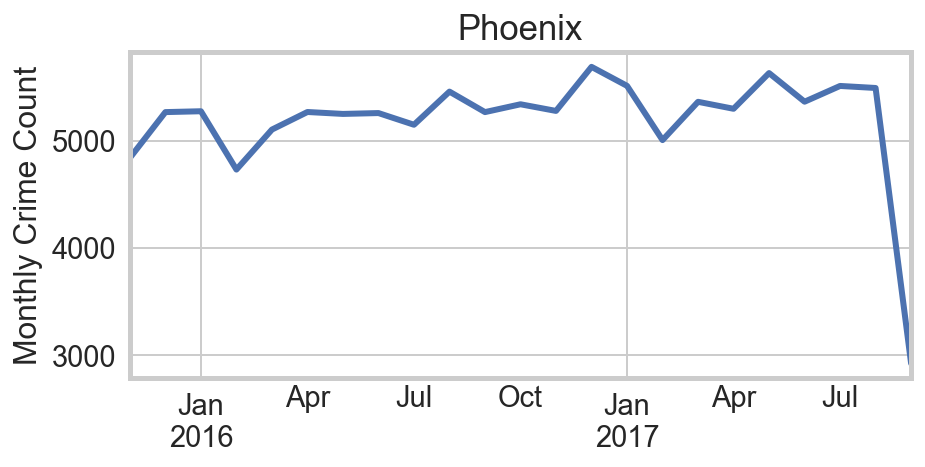

In [8]:
phoenix_crime = pd.read_csv("/media/jsaxon/brobdingnag/data/crime/phoenix_az.csv",
                            parse_dates = ["OCCURRED ON"], infer_datetime_format = True,
                            index_col = "OCCURRED ON", usecols = ["UCR CRIME CATEGORY", "OCCURRED ON"])
ax = phoenix_crime.index.name = "Date"
ax = phoenix_crime["UCR CRIME CATEGORY"].resample("1M").count().plot(title = "Phoenix")
ax.set_ylabel("Monthly Crime Count")
ax.set_xlabel("")

In [9]:
dallas_crime = pd.read_csv("/media/jsaxon/brobdingnag/data/crime/dallas_tx.csv",
                           usecols = ["Date1", "Time1", "OffIncident"], 
                           parse_dates = [["Date1", "Time1"]], infer_datetime_format = True,
                           index_col = "Date1_Time1")

non_criminal = dallas_crime["OffIncident"].str.contains("NO OFFENSE") | dallas_crime["OffIncident"].str.contains("ACCIDENT INV")
dallas_crime = dallas_crime[~non_criminal]

dallas_crime.set_index(pd.DatetimeIndex(dallas_crime.index), inplace = True)

dallas_crime = dallas_crime[dallas_crime.index.date > datetime.date(2014, 10, 1)]

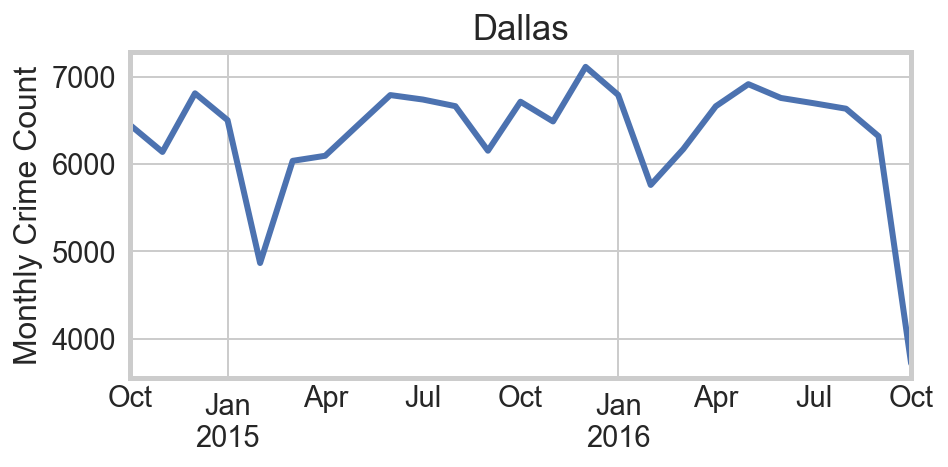

In [10]:
ax = dallas_crime["OffIncident"].resample("1M").count().plot(title = "Dallas")
ax.set_ylabel("Monthly Crime Count")
ax.set_xlabel("")

Wait a minute -- is it just Chicago?  Let's look at Philadelphia!

In [13]:
# ! cat /media/jsaxon/brobdingnag/data/crime/philadelphia_pa.csv | \
#      tail -n +2 | cut -f3 -d, | cut -f1 -d" " | sort | uniq -c | \
#      sed "s/ *\([0-9]*\) *\([0-9]\{2\}\)\/\([0-9]\{2\}\)\/\([0-9]\{4\}\)/\4\/\2\/\3,\1/" | \
#      sort > philly_crime_counts.csv

In [14]:
philly_crime = pd.read_csv("philly_crime_counts.csv", header = None,
                           names = ["Date", "Count"], index_col = "Date",
                           parse_dates = ["Date"], infer_datetime_format = True)

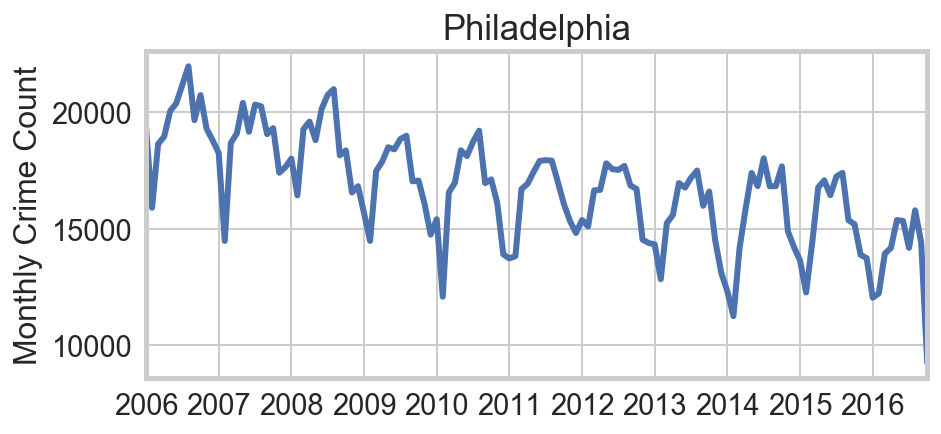

In [15]:
ax = philly_crime["Count"].resample("1M").sum().plot(title = "Philadelphia")
ax.set_xlabel("")
ax.set_ylabel("Monthly Crime Count");

Summer is still a time for crime, in the City of Brotherly Love.

### The Question is, what drives the variation?
Is it the absolute temperature only?  Or can the relative temperature (today is a nice day) also affect it?  Let's construct a few measures:

In [16]:
# This is the running average of neighboring weeks.
# The problem is that it remains correlated with the day in question.
weather_mdw["Yesterday [F]"] = weather_mdw['Temperature [F]'].shift(1)
weather_mdw["Tomorrow [F]"]  = weather_mdw['Temperature [F]'].shift(-1)

# The shift, using the same measure.
weather_mdw['Daily Diff [F]'] = weather_mdw['Temperature [F]'] - 0.5 * (weather_mdw['Yesterday [F]'] + weather_mdw["Tomorrow [F]"])
weather_mdw['Yesterday Diff [F]'] = weather_mdw['Temperature [F]'] - weather_mdw['Yesterday [F]']

weather_mdw.dropna(inplace = True)

There do not seem to be significant trends in the short-term shift comparisons, by season.

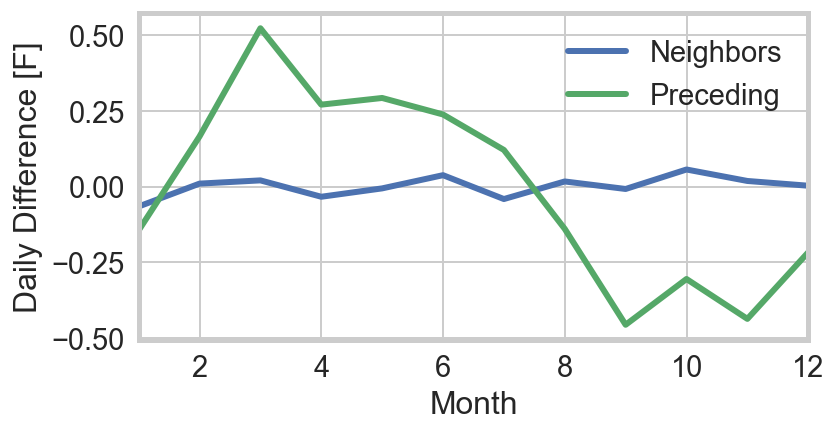

In [17]:
ax = weather_mdw["Daily Diff [F]"].groupby(weather_mdw.index.month).mean().plot(figsize = (6, 3), label = "Neighbors")
ax = weather_mdw['Yesterday Diff [F]'].groupby(weather_mdw.index.month).mean().plot(figsize = (6, 3), label = "Preceding")
ax.set_xlabel("Month");
ax.set_ylabel("Daily Difference [F]");
ax.legend()

Create similar ratios for crime:  We want to be able to look for changes in the daily crime counts, from daily temperature changes.

In [18]:
daily_crimes['Two Week Split [Count]'] = 0.5 * (daily_crimes['Count'].rolling(window = 7, center = False).mean().shift(-7) +
                                                daily_crimes['Count'].rolling(window = 7, center = False).mean().shift(1))

daily_crimes['Two Week Ratio [Count]'] = daily_crimes['Count'] / daily_crimes['Two Week Split [Count]']
daily_crimes.dropna(inplace = True)

Merge the two datasets.  Crime and year variables will be useful, since there are strong trends by year in the Chicago data.

In [19]:
cw = pd.concat([weather_mdw, daily_crimes], axis = 1).dropna()
cw.set_index(pd.DatetimeIndex(cw.index), inplace = True)
cw["Month"] = cw.index.month
cw["Year"] = (cw.index - datetime.datetime(2001, 1, 1, 0, 0, tzinfo = pytz.timezone('UTC'))) / datetime.timedelta(days=365.25)
cw["Yint"] = cw.index.year
cw["Day of Week"] = cw.index.dayofweek
cw["YestInt"] = (weather_mdw["Yesterday [F]"]/10.).round(1).astype(int)*10
cw["Precip"] = cw["Precipitation [In]"] > 0

There is very clear tempeature dependence, but also a huge spread.  Most of this is presumably from the secular trend over time.

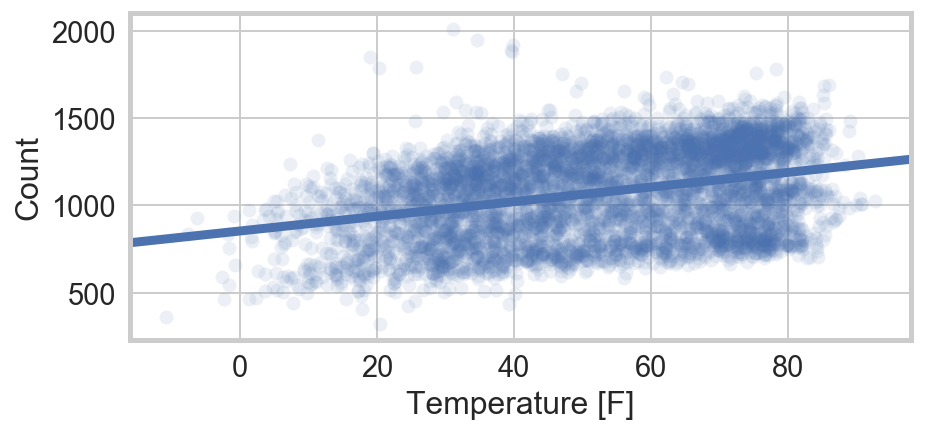

In [20]:
sns.regplot(x = "Temperature [F]", y = "Count", data = cw, scatter_kws = {"alpha" : 0.1});

The coefficient on the temperature is highly significant.

In [21]:
ols = smf.ols(formula = "NC ~ C(Yint) + C(DoW) + C(P)+ T + DD",
              data = cw.rename(columns = {"Count" : "NC", 
                                          "Temperature [F]"  : "T", 
                                          "Precip"           : "P", 
                                          "Daily Diff [F]"   : "DD",
                                          "Day of Week"      : "DoW"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NC   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1884.
Date:                Sun, 01 Oct 2017   Prob (F-statistic):               0.00
Time:                        15:42:27   Log-Likelihood:                -33576.
No. Observations:                5750   AIC:                         6.720e+04
Df Residuals:                    5725   BIC:                         6.737e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1081.4429      6.049    178.778      0.000    1069.584    1093.301
C(Yint)[T.2002]     4.1555      6.199      0.670      0.503      -7.997      16.308
C(Yint)[T.2003]   -14.6876      6.200     -2.369      0.018     -26.841      -2.534
C(Yint)[T.2004]   -40.2627      6.194     -6.500      0.000     -52.405     -28.120
C(Yint)[T.2005]   -86.5471      6.198    -13.964      0.000     -98.697     -74.397
C(Yint)[T.2006]  -103.9345      6.197    -16.772      0.000    -116.083     -91.786
C(Yint)[T.2007]  -129.3048      6.197    -20.864      0.000    -141.454    -117.155
C(Yint)[T.2008]  -148.2334      6.197    -23.920      0.000    -160.382    -136.085
C(Yint)[T.2009]  -238.5630      6.203    -38.458      0.000    -250.724    -226.402
C(Yint)[T.2010]  -313.0629      6.197    -50.516      0.000    -325.212    -300.914
C(Yint)[T.2011]  -360.6227      6.198    -58.179      0.000    -372.774    -348.471
C(Yint)[T.2012]  -425.2000      6.195    -68.640      0.000    -437.344    -413.056
C(Yint)[T.2013]  -477.9702      6.200    -77.098      0.000    -490.124    -465.817
C(Yint)[T.2014]  -561.6879      6.202    -90.571      0.000    -573.845    -549.530
C(Yint)[T.2015]  -608.9072      6.197    -98.254      0.000    -621.056    -596.758
C(Yint)[T.2016]  -621.5207      6.657    -93.357      0.000    -634.572    -608.469
C(DoW)[T.1]        19.9642      4.110      4.857      0.000      11.906      28.022
C(DoW)[T.2]        28.6811      4.110      6.979      0.000      20.624      36.738
C(DoW)[T.3]        19.0278      4.111      4.628      0.000      10.968      27.088
C(DoW)[T.4]        78.4653      4.114     19.075      0.000      70.401      86.529
C(DoW)[T.5]        17.6794      4.112      4.299      0.000       9.618      25.741
C(DoW)[T.6]       -43.8975      4.112    -10.676      0.000     -51.958     -35.837
C(P)[T.True]      -29.8673      2.377    -12.564      0.000     -34.527     -25.207
T                   4.5349      0.058     78.593      0.000       4.422       4.648
DD                 -0.9165      0.251     -3.656      0.000      -1.408      -0.425
==============================================================================
Omnibus:                     2010.240   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46529.441
Skew:                           1.129   Prob(JB):                         0.00
Kurtosis:                      16.752   Cond. No.                         924.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

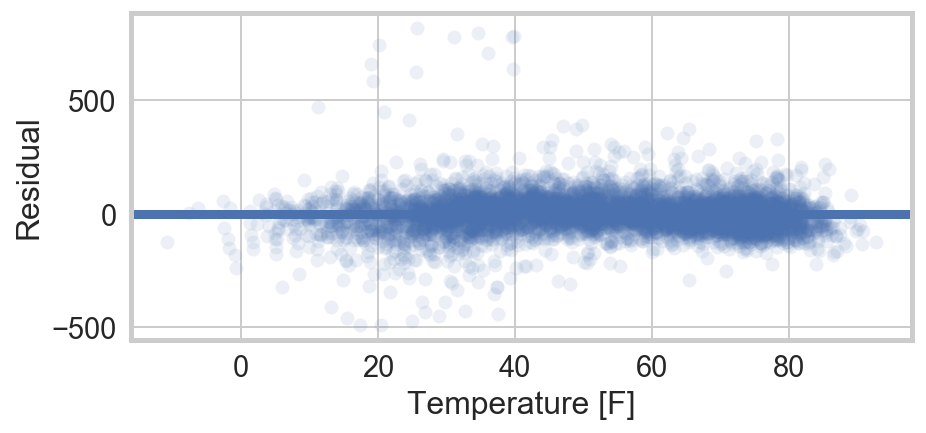

In [22]:
sns.regplot(x = cw["Temperature [F]"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.1});

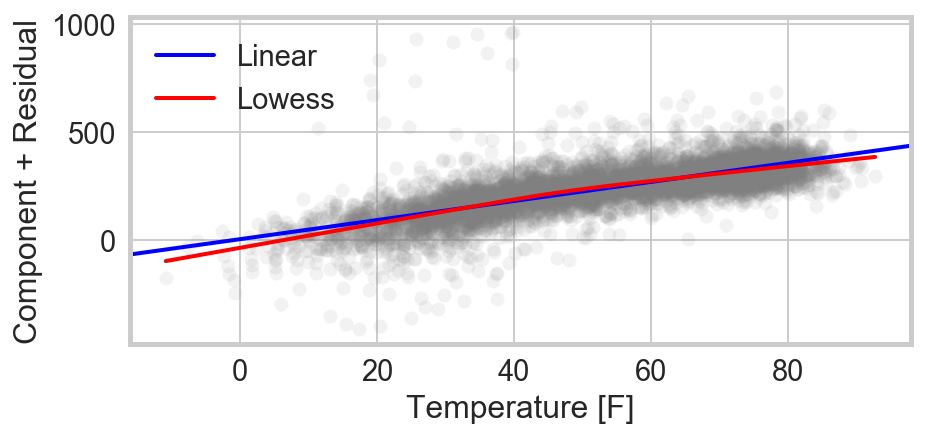

In [23]:
cpr = pd.Series(name = "Component + Residual", data = model.resid + cw["Temperature [F]"] * model.params["T"])
ax = sns.regplot(x = cw["Temperature [F]"], y = cpr, scatter = True, fit_reg = False,
            scatter_kws = {"alpha" : 0.1, "color" : "grey"})
sns.regplot(x = cw["Temperature [F]"], y = cpr, scatter = False, 
            lowess = False, robust = True, label = "Linear",
            scatter_kws = {"alpha" : 0.1, "color" : "grey"}, line_kws = {"color" : "blue", "linewidth" : 2})
sns.regplot(x = cw["Temperature [F]"], y = cpr, scatter = False, 
            lowess = True, label = "Lowess",
            scatter_kws = {"alpha" : 0}, line_kws = {"color" : "red", "linewidth" : 2}, ax = ax);

ax.legend()

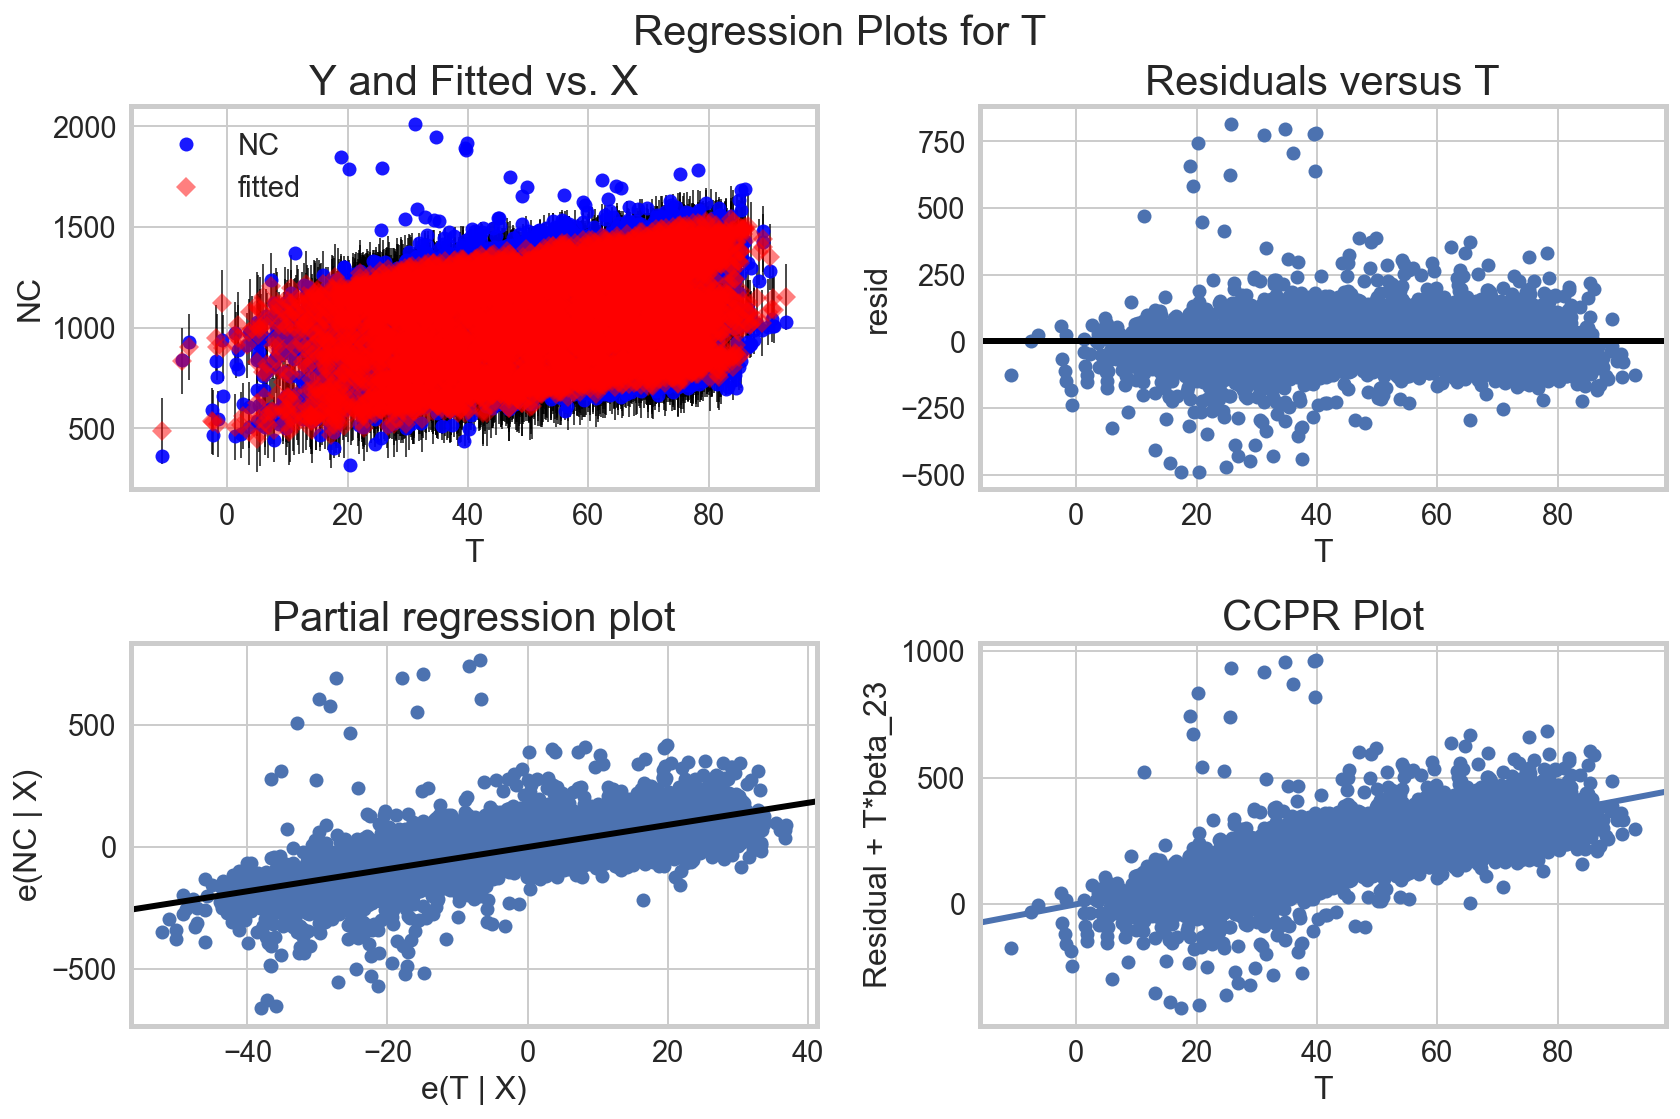

In [24]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, "T", fig=fig)

There are some pretty striking outliers here -- they're basically all January 1.  We'll come back to this.

In [25]:
cw[model.resid > 400].index

DatetimeIndex(['2002-01-01 06:00:00+00:00', '2003-01-01 06:00:00+00:00',
               '2004-01-01 06:00:00+00:00', '2005-01-01 06:00:00+00:00',
               '2006-01-01 06:00:00+00:00', '2007-01-01 06:00:00+00:00',
               '2008-01-01 06:00:00+00:00', '2009-01-01 06:00:00+00:00',
               '2010-01-01 06:00:00+00:00', '2011-01-01 06:00:00+00:00',
               '2012-01-01 06:00:00+00:00', '2013-01-01 06:00:00+00:00',
               '2014-01-01 06:00:00+00:00', '2015-01-01 06:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

# Outliers -- January 1

In [26]:
cw[cw["Two Week Ratio [Count]"] > 1.5]

,Temperature [F],Precipitation [In],Yesterday [F],Tomorrow [F],Daily Diff [F],Yesterday Diff [F],Count,Two Week Split [Count],Two Week Ratio [Count],Month,Year,Yint,Day of Week,YestInt,Precip
2002-01-01 06:00:00+00:00,18.962500,0.000000,15.362500,23.466667,-0.452083,3.600000,1850.0,1057.428571,1.749527,1,1.000000,2002,1,10,False
2003-01-01 06:00:00+00:00,31.133333,0.000000,34.770833,29.162500,-0.833333,-3.637500,2013.0,1154.142857,1.744152,1,1.999316,2003,2,30,False
2004-01-01 06:00:00+00:00,39.712000,0.000000,37.883333,50.204762,-4.332048,1.828667,1882.0,1067.571429,1.762880,1,2.998631,2004,3,30,False
2005-01-01 06:00:00+00:00,34.662162,0.033243,50.085185,44.422581,-12.591721,-15.423023,1949.0,1030.785714,1.890791,1,4.000684,2005,5,50,True
2006-01-01 06:00:00+00:00,39.546429,0.000000,34.503226,41.492308,1.548662,5.043203,1891.0,1095.428571,1.726265,1,5.000000,2006,6,30,False
2007-01-01 06:00:00+00:00,39.903704,0.000000,50.491429,36.829167,-3.756594,-10.587725,1919.0,1059.500000,1.811232,1,5.999316,2007,0,50,False
2008-01-01 06:00:00+00:00,20.208197,0.000000,30.238636,9.477419,0.350169,-10.030440,1787.0,1029.928571,1.735072,1,6.998631,2008,1,30,False
2009-01-01 06:00:00+00:00,25.704167,0.000000,17.853846,25.420833,4.066827,7.850321,1791.0,961.357143,1.862991,1,8.000684,2009,3,10,False
2010-01-01 06:00:00+00:00,11.304348,0.000000,25.986207,6.564286,-4.970898,-14.681859,1373.0,821.142857,1.672060,1,9.000000,2010,4,20,False
2011-01-01 06:00:00+00:00,25.503846,0.000000,51.044681,19.591667,-9.814328,-25.540835,1487.0,792.142857,1.877187,1,9.999316,2011,5,50,False


OK, so it's all New Year's day.  This doesn't seem to be a reporting issue -- t

In [27]:
! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv | grep ",01\/01\/20[01][0-9]" | cut -f6 -d, | sort | uniq -c | sort -n | sed "s/^ *\([0-9]*\) /\1,/" > new_years_crime.csv
! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv | grep ",01\/[0-3][0-9]\/20[01][0-9]" | cut -f6 -d, | sort | uniq -c | sort -n| sed "s/^ *\([0-9]*\) /\1,/" > january_crime.csv

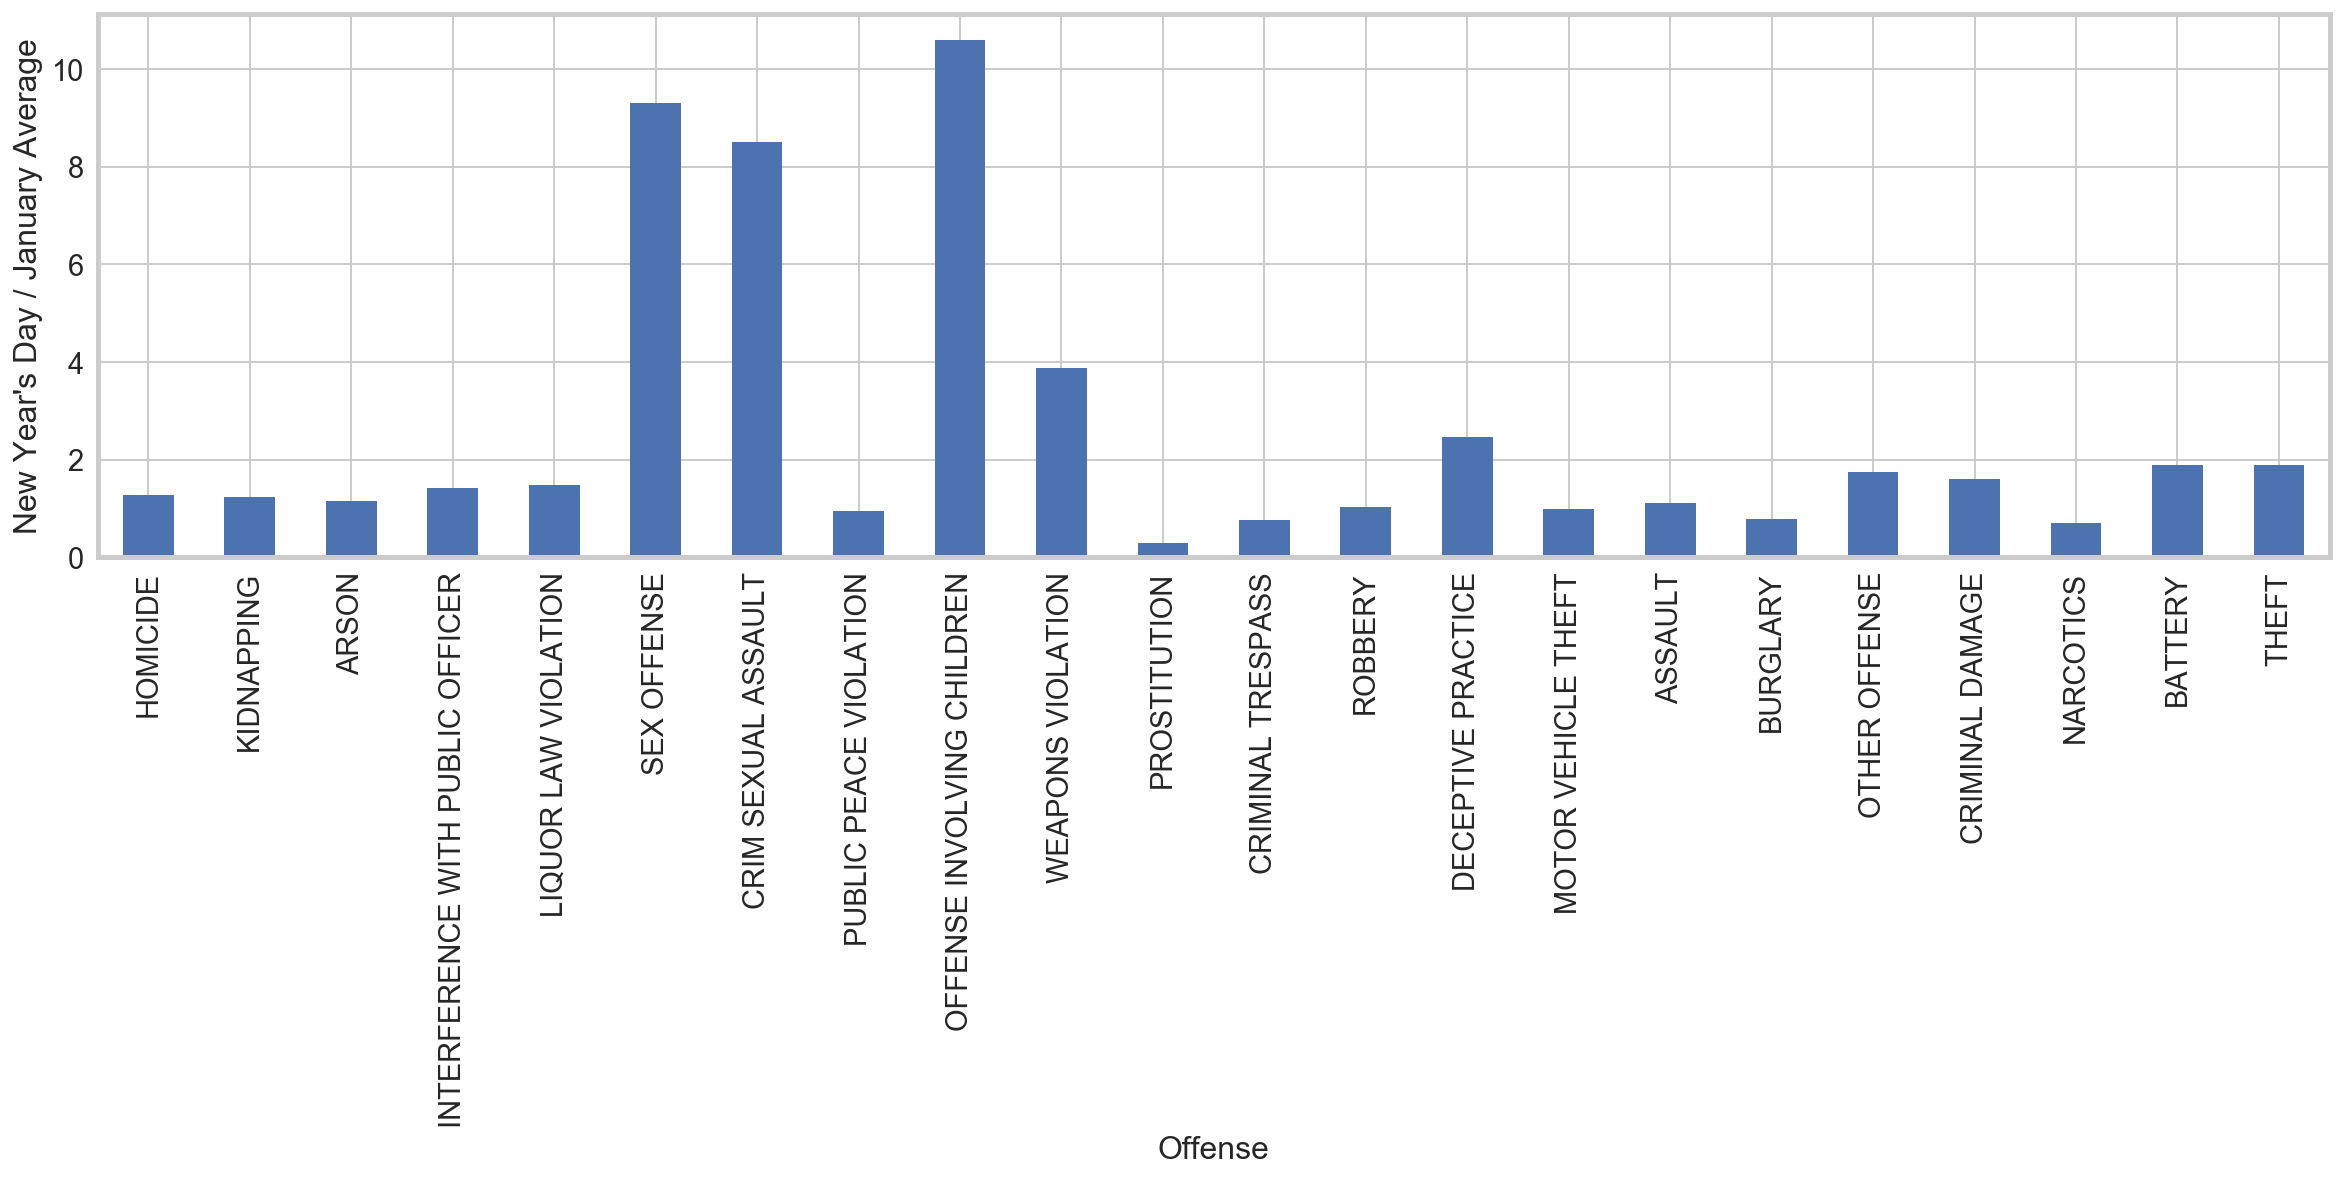

In [28]:
jan = pd.read_csv("january_crime.csv",   names = ["January", "Offense"])
nyd = pd.read_csv("new_years_crime.csv", names = ["NYD", "Offense"])
jan_check = pd.merge(jan, nyd)
jan_check["ratio"] = jan_check["NYD"] * 31 / jan_check["January"]
ax = jan_check[jan_check.NYD > 20].set_index("Offense")["ratio"].plot(kind = 'bar', figsize = (20, 5))
ax.set_ylabel("New Year's Day / January Average")

In [29]:
jan_check.sort_values(by = "January", ascending = False).head(10)[["Offense", "January", "NYD", "ratio"]].reset_index(drop = True)

,Offense,January,NYD,ratio
0,THEFT,99632,6107,1.900163
1,BATTERY,82358,5034,1.894825
2,NARCOTICS,60640,1398,0.714677
3,CRIMINAL DAMAGE,51790,2677,1.602375
4,OTHER OFFENSE,34592,1953,1.750202
5,BURGLARY,28125,718,0.791396
6,ASSAULT,26698,957,1.111207
7,MOTOR VEHICLE THEFT,25005,803,0.995521
8,DECEPTIVE PRACTICE,19260,1527,2.457788
9,ROBBERY,18942,636,1.040862


OK, well this is not something I wanted to know about New Year's: high crime across the board, but particularly sex crimes and crimes involving children.  Nevertheless, the "overall" excess of crimes comes from the usual heavy hitters -- theft and battery.

# Non-Linear Least Squares
Try a kink or a quadratic to find the "best" temperature to mug at.  I'm interested in whether there is an "maximal" temperature for time, and so I will focus on the afternoon, when it might be hot enough to see the turn-over.

In [30]:
import datetime
import numpy as np
from lmfit import minimize, Parameters, report_fit

In [31]:
weather_mdw = pd.read_csv("/media/jsaxon/brobdingnag/data/weather/MDW.csv", 
                          index_col = "DateUTC", parse_dates = ["DateUTC"], 
                          usecols = ["DateUTC", "Temperature [F]", "Precipitation [In]"])

weather_mdw.set_index(weather_mdw.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Central')), inplace = True)

In [32]:
afternoon_weather = weather_mdw[(12 <= weather_mdw.index.hour) & (weather_mdw.index.hour < 18)]
afternoon_avg_temp = pd.DataFrame(afternoon_weather["Temperature [F]"].resample("1D").mean())

In [33]:
# This is just wildly faster by command line.
# If need be, we can make it python
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv \
#       | cut -f3 -d"," | grep PM | grep " [01][12345]" \
#       | cut -f1 -d " " \
#       | sed "s/\(..\)\/\(..\)\/\(....\)/\3\/\1\/\2/" \
#       | sort | uniq -c | grep -v "[A-Z]" \
#       > chicago_afternoon_crime_counts.csv

In [34]:
afternoon_crimes = pd.read_csv("chicago_afternoon_crime_counts.csv", index_col = "Date", parse_dates = True,
                           delim_whitespace = True, names = ["Count", "Date"])

afternoon_crimes.set_index(afternoon_crimes.index.tz_localize(pytz.timezone('US/Central')), inplace = True) 

In [35]:
ct_mdw = pd.concat([afternoon_avg_temp, afternoon_crimes], axis = 1).dropna()
ct_mdw.set_index(ct_mdw.index.tz_convert(pytz.timezone('US/Central')), inplace = True)

In [36]:
ct_mdw["Year"] = (ct_mdw.index - datetime.datetime(2001, 1, 1, 0, 0, tzinfo = pytz.timezone('US/Central'))) / datetime.timedelta(days=365.25)
ct_mdw["Yint"] = ct_mdw.index.year
ct_mdw["DoW"] = ct_mdw.index.dayofweek

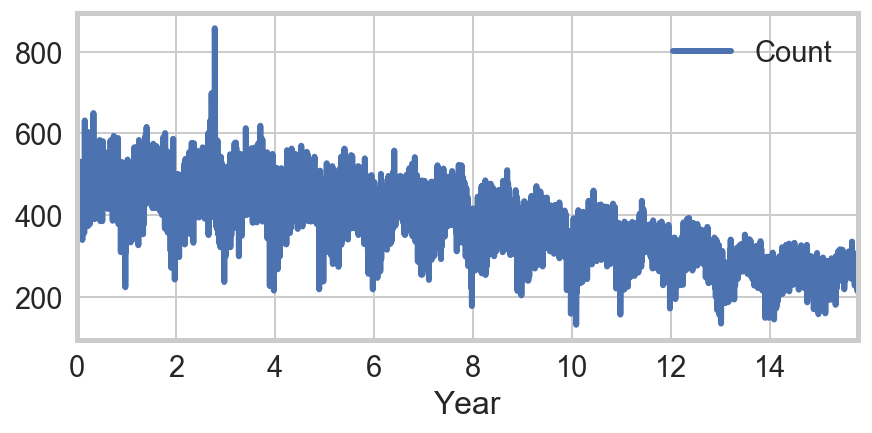

In [37]:
ct_mdw.plot(x = "Year", y = "Count")

In [38]:
ols = smf.ols(formula = "NC ~ Year",
              data = ct_mdw.rename(columns = {"Count" : "NC", 
                                              "Temperature [F]" : "T"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NC   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                 1.158e+04
Date:                Sun, 01 Oct 2017   Prob (F-statistic):               0.00
Time:                        15:43:39   Log-Likelihood:                -30933.
No. Observations:                5764   AIC:                         6.187e+04
Df Residuals:                    5762   BIC:                         6.188e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    506.7847      1.365    371.287      0.000     504.109     509.460
Year         -16.1249      0.150   -107.621      0.000     -16.419     -15.831
==============================================================================
Omnibus:                      310.467   Durbin-Watson:                   1.107
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.049
Skew:                          -0.272   Prob(JB):                    2.37e-188
Kurtosis:                       4.817   Cond. No.                         18.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

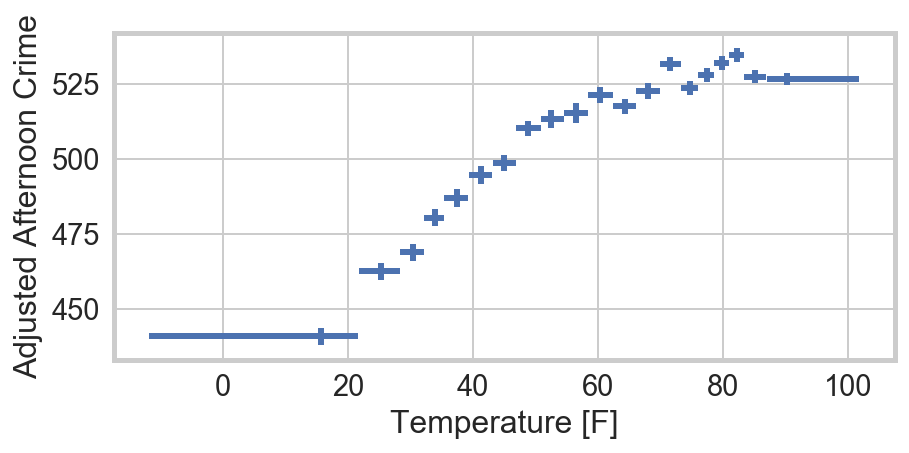

In [39]:
ct_mdw["Adjusted Count"] = ct_mdw["Count"] - ct_mdw.Year * model.params["Year"]

fig, ax = plt.subplots()
binned_df = ct_mdw.groupby(pd.qcut(ct_mdw["Temperature [F]"], 20))
ax.errorbar(x = binned_df.mean()["Temperature [F]"], 
            y = binned_df.mean()["Adjusted Count"],
            xerr = [binned_df.mean()["Temperature [F]"] - binned_df.min()["Temperature [F]"], 
                    binned_df.max()["Temperature [F]"] - binned_df.mean()["Temperature [F]"]],
            yerr = binned_df.std()["Adjusted Count"] / np.sqrt(binned_df.count()["Adjusted Count"]), 
            fmt="none", figsize = (5, 3))
ax.set(xlabel = "Temperature [F]", ylabel = "Adjusted Afternoon Crime");

In [40]:
ols = smf.ols(formula = "NC ~ Year + T",
              data = ct_mdw.rename(columns = {"Count" : "NC", 
                                              "Temperature [F]" : "T"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     NC   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     8231.
Date:                Sun, 01 Oct 2017   Prob (F-statistic):               0.00
Time:                        15:43:40   Log-Likelihood:                -30218.
No. Observations:                5764   AIC:                         6.044e+04
Df Residuals:                    5761   BIC:                         6.046e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    443.1979      1.987    223.068      0.000     439.303     447.093
Year         -16.3125      0.132   -123.160      0.000     -16.572     -16.053
T              1.1419      0.028     40.269      0.000       1.086       1.197
==============================================================================
Omnibus:                      336.126   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1426.208
Skew:                           0.052   Prob(JB):                    2.01e-310
Kurtosis:                       5.435   Cond. No.                         202.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

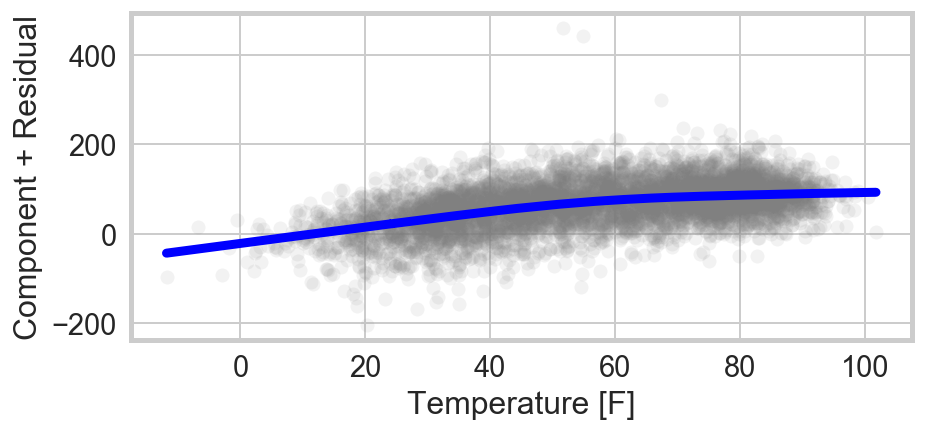

In [41]:
cpr = pd.Series(name = "Component + Residual", data = model.resid + ct_mdw["Temperature [F]"] * model.params["T"])
sns.regplot(x = ct_mdw["Temperature [F]"], y = cpr, lowess = True, 
            scatter_kws = {"alpha" : 0.1, "color" : "grey"}, line_kws = {"color" : "blue"});

We are now fitting the piecewise function,
$$Crime \sim \alpha + \beta_Y Y + \begin{cases}
             \beta_T T  & \text{if } T < T_\text{cut} \\
             \beta_T T_\text{cut} + \beta_{T,\text{high}} (T-T_\text{cut})  & \text{if } T \ge T_\text{cut}
       \end{cases}$$

In [42]:
def residual_kink(vars, T, Y, data):
    
    base   = vars["base"]
    Tcut   = vars["Tcut"]
    betaT  = vars["betaT"]
    betaTh = vars["betaTh"]
    betaY  = vars["betaY"]

    model = base + Y * betaY + np.where(T < Tcut, T * betaT, Tcut*betaT + (T - Tcut) * betaTh) 

    return (data - model) / np.sqrt(data)


params = Parameters()
params.add('betaT', value = 2.4,  min = 0, max = 10)
params.add('betaTh', value = 0,  min =-3, max = 3)
params.add('betaY', value = -16.3,  min = -50, max = 0)
params.add('Tcut', value = 70,  min = 0, max = 120)
params.add('base', value = 443.2, min = 300, max = 700)

out = minimize(residual_kink, params, 
               args=(ct_mdw["Temperature [F]"], ct_mdw["Year"], ct_mdw["Count"]),
               method = "leastsq")

report_fit(out)

[[Fit Statistics]]
    # function evals   = 66
    # data points      = 5764
    # variables        = 5
    chi-square         = 31490.518
    reduced chi-square = 5.468
    Akaike info crit   = 9797.588
    Bayesian info crit = 9830.885
[[Variables]]
    betaT:    2.00408567 +/- 0.079329 (3.96%) (init= 2.4)
    betaTh:   0.56979768 +/- 0.070193 (12.32%) (init= 0)
    betaY:   -16.3231342 +/- 0.127333 (0.78%) (init=-16.3)
    Tcut:     51.6981128 +/- 1.610058 (3.11%) (init= 70)
    base:     406.040203 +/- 3.093461 (0.76%) (init= 443.2)
[[Correlations]] (unreported correlations are <  0.100)
    C(betaT, base)               = -0.890 
    C(betaTh, Tcut)              = -0.623 
    C(betaT, Tcut)               = -0.595 
    C(Tcut, base)                =  0.420 
    C(betaY, base)               = -0.378 


###### As for the quadratic model, I basically can't get it to converge.

In [43]:
params = Parameters()
params.add('betaT', value = 0,  min = -5, max = 5)
params.add('wT', value = 1,  min = 0, max = 5)
params.add('betaY', value = -13.3,  min = -100, max = 0)
params.add('Topt', value = 50,  min = 0,  max = 200)
params.add('base', value = 500, min = 200, max = 700)

def residual_quad(vars, T, Y, data):
    
    base  = vars["base"]
    Topt  = vars["Topt"]
    betaT = vars["betaT"]
    wT    = vars["wT"]
    betaY = vars["betaY"]

    model = base + np.power((Topt - T) * wT, 2) * betaT + Y * betaY

    return (data - model) / np.sqrt(data)


out = minimize(residual_quad, params, 
               args=(ct_mdw["Temperature [F]"], ct_mdw["Year"], ct_mdw["Count"]),
               method = "leastsq")

report_fit(out)

[[Fit Statistics]]
    # function evals   = 94
    # data points      = 5764
    # variables        = 5
    chi-square         = 34178.014
    reduced chi-square = 5.935
    Akaike info crit   = 10269.637
    Bayesian info crit = 10302.934
[[Variables]]
    betaT:   0.00347171 +/- 740.6258 (21333136.84%) (init= 0)
    wT:      1.72516130 +/- 1.84e+05 (10666840.60%) (init= 1)
    betaY:  -16.4219537 +/- 0.132730 (0.81%) (init=-13.3)
    Topt:    4.3202e-09 +/- 0.158016 (3657616929.63%) (init= 50)
    base:    464.972881 +/- 3.732491 (0.80%) (init= 500)
[[Correlations]] (unreported correlations are <  0.100)
    C(betaT, wT)                 = -1.000 
    C(Topt, base)                = -0.906 
    C(betaY, base)               = -0.338 


### We would hope to see the turn-over, more clearly, in Phoenix.

In [44]:
# This is just wildly faster by command line.
# If need be, we can make it python
! cat /media/jsaxon/brobdingnag/data/crime/phoenix_az.csv \
      | cut -d, -f2 | grep "  1[2-7]:" | cut -f1 -d " " \
      | sed "s/\(..\)\/\(..\)\/\(....\)/\3\/\1\/\2/" \
      | sort | uniq -c | grep -v "[A-Z]" \
      > phoenix_afternoon_crime_counts.csv

In [45]:
phx_afternoon_crimes = pd.read_csv("phoenix_afternoon_crime_counts.csv", index_col = "Date", parse_dates = True,
                           delim_whitespace = True, names = ["Count", "Date"])

phx_afternoon_crimes.set_index(phx_afternoon_crimes.index.tz_localize(pytz.timezone('US/Mountain')), inplace = True)

In [46]:
weather_phx = pd.read_csv("/media/jsaxon/brobdingnag/data/weather/PHX.csv", 
                          index_col = "DateUTC", parse_dates = ["DateUTC"], 
                          usecols = ["DateUTC", "Temperature [F]", "Precipitation [In]"])

weather_phx.set_index(weather_phx.index.tz_localize(pytz.UTC).tz_convert(pytz.timezone('US/Mountain')), inplace = True)

phx_afternoon_weather = weather_phx[(12 <= weather_phx.index.hour) & (weather_phx.index.hour < 18)]
phx_afternoon_avg_temp = pd.DataFrame(phx_afternoon_weather["Temperature [F]"].resample("1D").mean())

In [47]:
ct_phx = pd.concat([phx_afternoon_avg_temp, phx_afternoon_crimes], axis = 1).dropna()

Well, this is already above Chicago's turn-on.  But it seems Phoenicians don't like (even more) heat.

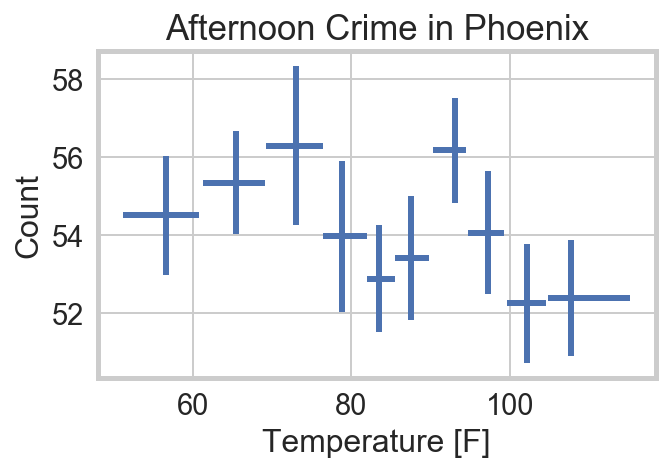

In [48]:
fig, ax = plt.subplots(figsize=(5, 3))
binned_df = ct_phx.groupby(pd.qcut(ct_phx["Temperature [F]"], 10))
ax.errorbar(x = binned_df.mean()["Temperature [F]"], 
            y = binned_df.mean()["Count"],
            xerr = [binned_df.mean()["Temperature [F]"] - binned_df.min()["Temperature [F]"], 
                    binned_df.max()["Temperature [F]"] - binned_df.mean()["Temperature [F]"]],
            yerr = binned_df.std()["Count"] / np.sqrt(binned_df.count()["Count"]), 
            fmt="none", figsize = (5, 3))
ax.set(xlabel = "Temperature [F]", ylabel = "Count", title = "Afternoon Crime in Phoenix");

# Various Types of Crime

In [51]:
# # This is just wildly faster by command line.
# ! cat /media/jsaxon/brobdingnag/data/crime/chicago_il.csv | tail -n +2\
#       | cut -f3,6 -d, \
#       | sed "s/\([01][0-9]\)\/\([0-3][0-9]\)\/\(20[01][0-9]\)/\3\/\1\/\2/" \
#       | sed "s/ [01][0-9]:[0-5][0-9]:[0-5][0-9] [AP]M//" | sort | uniq -c \
#       | sed -e "s/ *//" -e "s/ /,/" \
#       > chicago_crime_types.csv

In [52]:
chicago_types = pd.read_csv("chicago_crime_types.csv", 
                            parse_dates = ["Date"],
                            names = ["Count", "Date", "Type"])

common_crimes = chicago_types.groupby("Type").sum()["Count"].sort_values(ascending = False).head(20).index.tolist()

chicago_types = chicago_types[chicago_types.Type.isin(common_crimes)]
chicago_types["Year"] = chicago_types.Date.dt.year
chicago_types["DoW"] = chicago_types.Date.dt.dayofweek

weather_mdw["Date"] = pd.to_datetime(weather_mdw.index.date)

chicago_types = pd.merge(weather_mdw[["Temperature [F]", "Date"]], chicago_types)

In [54]:
from sklearn import linear_model
from scipy import stats

corr = []
for cr in common_crimes:
    regr = linear_model.LinearRegression()

    df = chicago_types[chicago_types.Type == cr].copy()

    regr.fit(df[["Year"]], df[["Count"]])
    df["resid"] = df[["Count"]] - regr.predict(df[["Year"]])

    r = stats.pearsonr(df["resid"], df["Temperature [F]"])
    corr.append((cr, r[0], r[1]))
    
pd.DataFrame(corr, columns = ["Offense", "R", "p"]).sort_values(by = "R", ascending = False).reset_index(drop = True).head(10)

,Offense,R,p
0,BATTERY,0.604118,0.0
1,ASSAULT,0.587209,0.0
2,THEFT,0.522527,0.0
3,CRIMINAL DAMAGE,0.506202,0.0
4,GAMBLING,0.416715,0.0
5,ROBBERY,0.355936,0.0
6,BURGLARY,0.312967,0.0
7,PUBLIC PEACE VIOLATION,0.267490,0.0
8,WEAPONS VIOLATION,0.256215,0.0
9,MOTOR VEHICLE THEFT,0.174238,0.0
